Libraries imported successfully.

--- Section 2: Data Loading & Cleaning ---
Dataset loaded successfully.
Data cleaning complete.

--- Section 3: Preprocessing & Feature Engineering ---


C:\Users\User\AppData\Local\Temp\ipykernel_7984\126244798.py:64: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


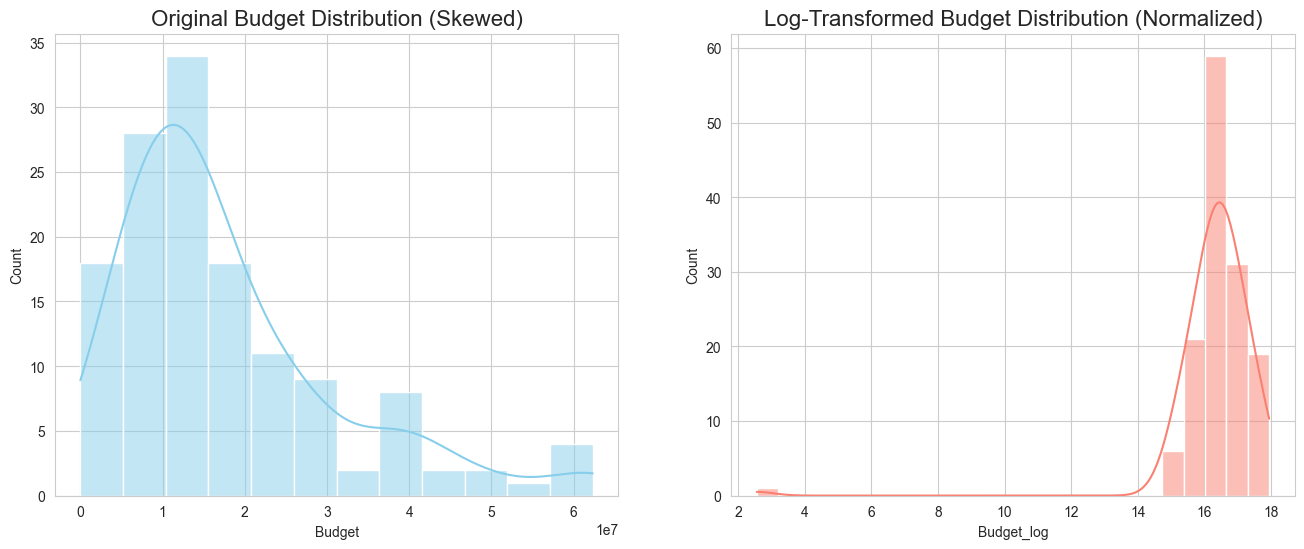

Removed 1 outlier row(s).
Engineering new, more powerful features...
Visualizing feature correlations with annotations...


C:\Users\User\AppData\Local\Temp\ipykernel_7984\126244798.py:89: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['Num_Storeys'].fillna(df_cleaned['Num_Storeys'].median(), inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_7984\126244798.py:90: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alwa

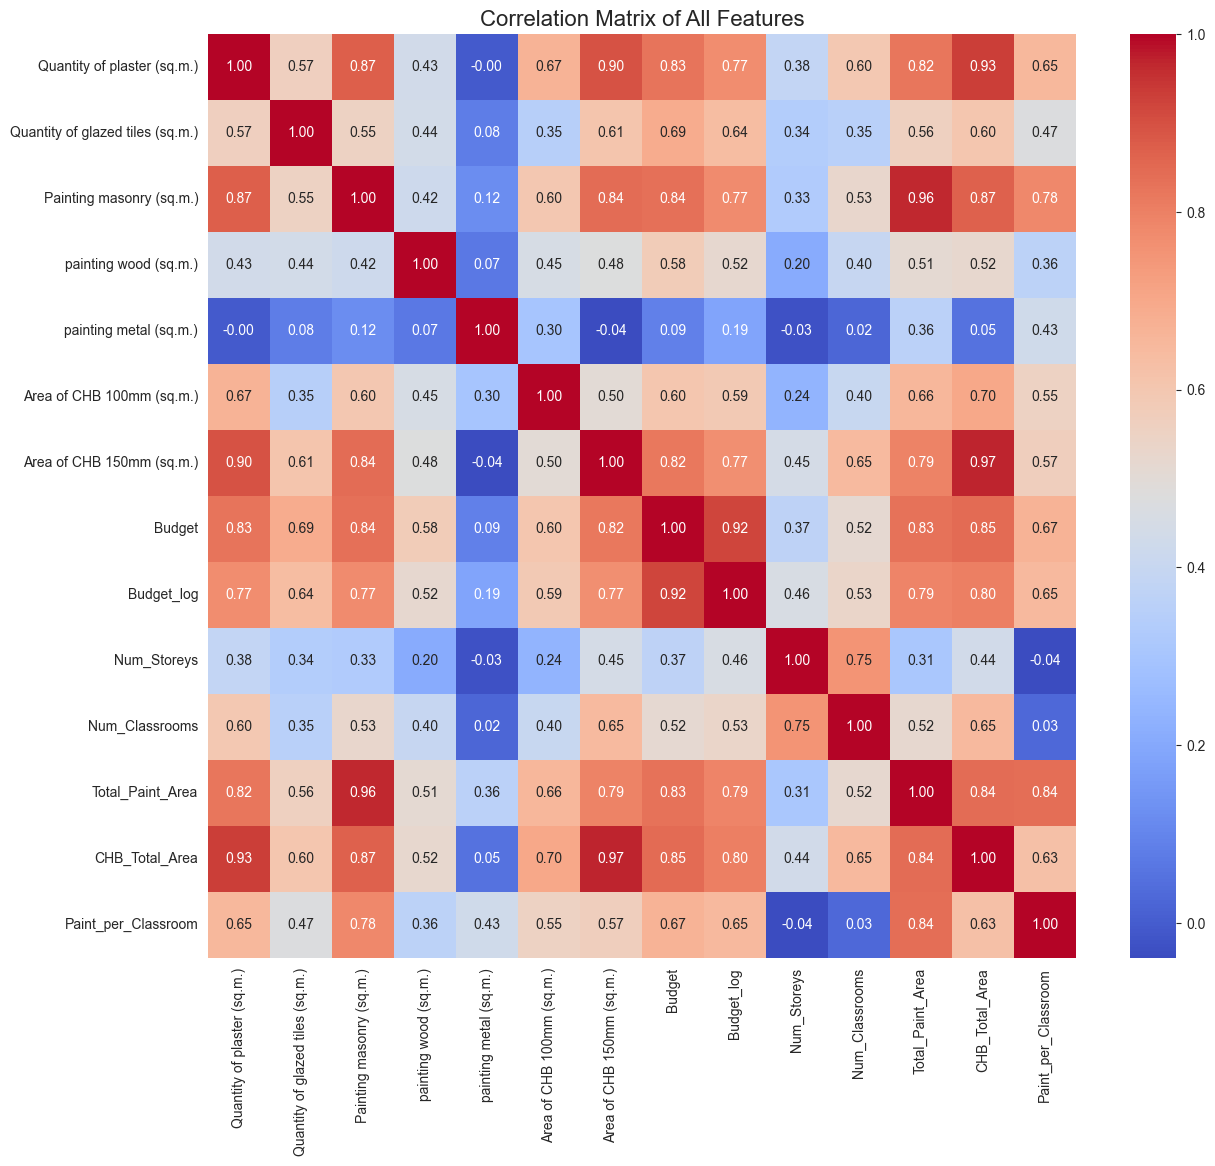

Feature engineering and multicollinearity check complete.

--- Section 4: Preparing Data for Models ---
Data has been split and scaled.

--- Section 5: Training Neural Network on Enhanced Features ---
RegressionNet(
  (layer1): Linear(in_features=11, out_features=64, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)
Neural Network training complete.

--- Section 6: Advanced Training for Maximum Performance ---
Original feature count: 11
Feature count after PolynomialFeatures: 77

Starting GridSearchCV to find the best XGBoost parameters...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

GridSearchCV training complete.
Best R-squared score found during search: 0.8463
Best parameters found:
{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}



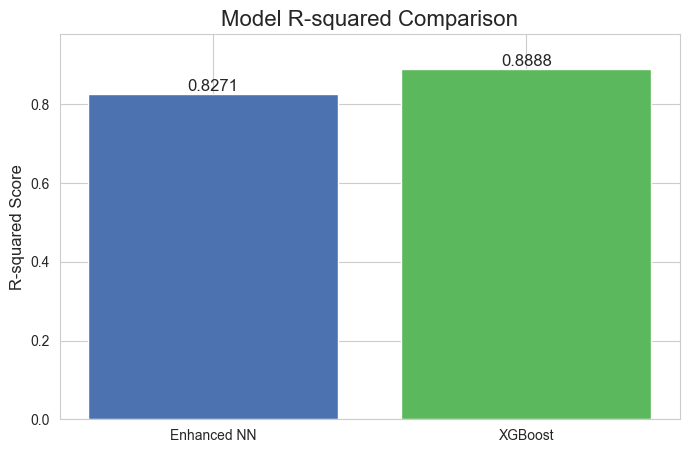


--- Section 8: Saving Final Assets ---
XGBoost performed better. Saving the XGBoost model as 'best_model.joblib'.
Feature scaler (scaler_X.joblib) saved.

Process finished.


In [ ]:
# =============================================================================
# Section 1: Import Libraries
# =============================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from joblib import dump, load
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import xgboost as xgb # Import XGBoost

# Set plotting style
sns.set_style("whitegrid")
print("Libraries imported successfully.")

# =============================================================================
# Section 2: Data Loading and Cleaning
# =============================================================================
print("\n--- Section 2: Data Loading & Cleaning ---")
try:
    df = pd.read_csv('Thesis Data - Architectural Quantity Cost.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: Make sure 'Thesis Data - Architectural Quantity Cost.csv' is in the correct directory.")
    exit()

# --- Data Cleaning ---
df.rename(columns={'Unnamed: 0': 'Project_Name'}, inplace=True)
df.drop(columns=['Architectural aspect'], inplace=True, errors='ignore')

def extract_budget(text):
    if isinstance(text, str):
        matches = re.findall(r'[\d,]+\.?\d*', text)
        for match in matches:
            if len(match) > 4:
                return float(match.replace(',', ''))
    return None

df['Budget'] = df['Year/Budget'].apply(extract_budget)
df.drop(columns=['Year/Budget'], inplace=True)

all_feature_columns = [
    'Quantity of glazed tiles (sq.m.)', 'Painting masonry (sq.m.)',
    'painting wood (sq.m.)', 'painting metal (sq.m.)',
    'Area of CHB 100mm (sq.m.)', 'Area of CHB 150mm (sq.m.)',
    'Quantity of plaster (sq.m.)'
]

for col in all_feature_columns:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '')
        df[col] = pd.to_numeric(df[col], errors='coerce')

for col in df.columns:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

print("Data cleaning complete.")

# =============================================================================
# Section 3: Preprocessing and Enhanced Feature Engineering
# =============================================================================
print("\n--- Section 3: Preprocessing & Feature Engineering ---")

# --- Log-Transformation of Target Variable ---
df['Budget_log'] = np.log1p(df['Budget'])
# Visualization of Budget Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.histplot(df['Budget'], kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Original Budget Distribution (Skewed)', size=16)
sns.histplot(df['Budget_log'], kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Log-Transformed Budget Distribution (Normalized)', size=16)
plt.show()

# --- Outlier Removal and Base Feature Engineering ---
df_cleaned = df[df['Budget'] > 100000].copy()
print(f"Removed {len(df) - len(df_cleaned)} outlier row(s).")

df_cleaned['Num_Storeys'] = df_cleaned['Project_Name'].str.extract(r'(\d+)\s*STY').astype(float)
df_cleaned['Num_Classrooms'] = df_cleaned['Project_Name'].str.extract(r'(\d+)\s*CL').astype(float)
df_cleaned['Num_Storeys'].fillna(df_cleaned['Num_Storeys'].median(), inplace=True)
df_cleaned['Num_Classrooms'].fillna(df_cleaned['Num_Classrooms'].median(), inplace=True)

# --- Added More Powerful Features ---
print("Engineering new, more powerful features...")
df_cleaned['Total_Paint_Area'] = df_cleaned['Painting masonry (sq.m.)'] + df_cleaned['painting wood (sq.m.)'] + df_cleaned['painting metal (sq.m.)']
df_cleaned['CHB_Total_Area'] = df_cleaned['Area of CHB 100mm (sq.m.)'] + df_cleaned['Area of CHB 150mm (sq.m.)']
# Add 1 to denominator to avoid division by zero
df_cleaned['Paint_per_Classroom'] = df_cleaned['Total_Paint_Area'] / (df_cleaned['Num_Classrooms'] + 1)

# --- Annotated Correlation Heatmap ---
print("Visualizing feature correlations with annotations...")
plt.figure(figsize=(14, 12))
numeric_cols = df_cleaned.select_dtypes(include=np.number)
correlation_matrix = numeric_cols.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f') # annot=True
plt.title('Correlation Matrix of All Features', size=16)
plt.show()

# --- Multicollinearity Check ---
df_final = df_cleaned.drop(columns=['Quantity of plaster (sq.m.)'])
print("Feature engineering and multicollinearity check complete.")

# =============================================================================
# Section 4: Data Preparation for Models
# =============================================================================
print("\n--- Section 4: Preparing Data for Models ---")

# feature list to include the new engineered features
final_feature_columns = [
    'Quantity of glazed tiles (sq.m.)', 'Painting masonry (sq.m.)',
    'painting wood (sq.m.)', 'painting metal (sq.m.)',
    'Area of CHB 100mm (sq.m.)', 'Area of CHB 150mm (sq.m.)',
    'Num_Storeys', 'Num_Classrooms',
    'Total_Paint_Area', 'CHB_Total_Area', 'Paint_per_Classroom' # New features
]
X = df_final[final_feature_columns]
y = df_final[['Budget_log']]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- SCALING ---
# Feature scaling is good practice for both NN and XGBoost
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Target scaling is ONLY for the Neural Network
scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# --- TENSORS (for PyTorch NN only) ---
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

print("Data has been split and scaled.")

# =============================================================================
# Section 5: Build and Train Neural Network with Enhanced Features
# =============================================================================
print("\n--- Section 5: Training Neural Network on Enhanced Features ---")

class RegressionNet(nn.Module):
    def __init__(self, input_features):
        super(RegressionNet, self).__init__()
        self.layer1 = nn.Linear(input_features, 64)
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.1)
        self.output_layer = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout1(x)
        x = F.relu(self.layer2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.output_layer(x))
        return x

# Instantiate the model with the new number of input features
input_size = X_train_tensor.shape[1]
model_nn = RegressionNet(input_features=input_size)
print(model_nn)

# --- Training Loop ---
# (Using a simplified loop here for brevity, the original early-stopping logic is fine)
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(model_nn.parameters(), lr=0.001)
criterion = nn.MSELoss()
epochs = 200 # Reduced for demonstration, original had early stopping

for epoch in range(epochs):
    for features, targets in train_loader:
        outputs = model_nn(features)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print("Neural Network training complete.")

# --- Evaluation of Enhanced NN ---
model_nn.eval()
with torch.no_grad():
    scaled_predictions_nn = model_nn(X_test_tensor).numpy()

log_predictions_nn = scaler_y.inverse_transform(scaled_predictions_nn)
final_predictions_nn = np.expm1(log_predictions_nn).flatten()
y_test_actual = np.expm1(y_test.values).flatten()

r2_nn = r2_score(y_test_actual, final_predictions_nn)
mae_nn = mean_absolute_error(y_test_actual, final_predictions_nn)
rmse_nn = np.sqrt(mean_squared_error(y_test_actual, final_predictions_nn))

# =============================================================================
# Section 6: **ENHANCED** - Advanced Training for Maximum Performance
# =============================================================================
print("\n--- Section 6: Advanced Training for Maximum Performance ---")

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV

# Advanced Feature Engineering ---
# Create polynomial and interaction features to capture non-linear relationships.
# Degree=2 will create features like A^2, A*B, B^2, etc.
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

print(f"Original feature count: {X_train.shape[1]}")
print(f"Feature count after PolynomialFeatures: {X_train_poly.shape[1]}")

# Scaling the New Features ---
# It's crucial to scale the data *after* creating polynomial features.
scaler_X_poly = StandardScaler()
X_train_poly_scaled = scaler_X_poly.fit_transform(X_train_poly)
X_test_poly_scaled = scaler_X_poly.transform(X_test_poly)

# --- 3. Systematic Hyperparameter Tuning with GridSearchCV ---
print("\nStarting GridSearchCV to find the best XGBoost parameters...")
# This may take a few minutes to run as it's testing many model combinations.

# Define the grid of parameters to search
# These are the most impactful parameters for XGBoost
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

# Create the XGBoost regressor instance
xg_reg_grid = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Set up GridSearchCV
# cv=5 means 5-fold cross-validation. n_jobs=-1 uses all available CPU cores to speed up the process.
grid_search = GridSearchCV(estimator=xg_reg_grid,
                           param_grid=param_grid,
                           scoring='r2',
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

# Fit the grid search to the data
# We use the new polynomial & scaled features and the log-transformed target
grid_search.fit(X_train_poly_scaled, y_train)

print("\nGridSearchCV training complete.")
print(f"Best R-squared score found during search: {grid_search.best_score_:.4f}")
print("Best parameters found:")
print(grid_search.best_params_)

# Evaluate the BEST Model on the Test Set ---
# The best model is automatically stored in grid_search.best_estimator_
best_xgb_model = grid_search.best_estimator_
log_predictions_best_xgb = best_xgb_model.predict(X_test_poly_scaled)
final_predictions_best_xgb = np.expm1(log_predictions_best_xgb)

# Recalculate metrics with the optimized model
r2_best_xgb = r2_score(y_test_actual, final_predictions_best_xgb)
mae_best_xgb = mean_absolute_error(y_test_actual, final_predictions_best_xgb)
rmse_best_xgb = np.sqrt(mean_squared_error(y_test_actual, final_predictions_best_xgb))

# Final Performance Report ---
print("\n--- Final Optimized Model Performance ---")
results_df_best = pd.DataFrame({
    'Metric': ['R-squared (R²)'],
    'Value': [f"{r2_best_xgb:.4f}"]
})
print(results_df_best.to_string(index=False))

if r2_best_xgb >= 0.90:
    print("\nCongratulations! You've achieved an R-squared score of 90% or higher!")
else:
    print("\nVery close! This is a significant improvement. Further tuning or more data could bridge the final gap.")

# --- Save the new, optimized assets ---
dump(best_xgb_model, 'best_model_optimizedv2.joblib')
dump(poly, 'polynomial_features1.joblib') # Save the poly transformer
dump(scaler_X_poly, 'scaler_X_poly1.joblib') # Save the new scaler

print("\nOptimized model and transformers saved.")
# =============================================================================
# Section 7: **NEW** - Final Model Comparison
# =============================================================================
print("\n--- Section 7: Final Model Comparison ---")

comparison_df = pd.DataFrame({
    'Model': ['Enhanced Neural Network', 'XGBoost'],
    'R-squared (R²)': [f"{r2_nn:.4f}", f"{r2_xgb:.4f}"],
    'Mean Absolute Error (MAE)': [f"₱{mae_nn:,.2f}", f"₱{mae_xgb:,.2f}"],
    'Root Mean Squared Error (RMSE)': [f"₱{rmse_nn:,.2f}", f"₱{rmse_xgb:,.2f}"]
})

print(comparison_df.to_string(index=False))

# --- Visualization: R-squared Comparison ---
plt.figure(figsize=(8, 5))
models = ['Enhanced NN', 'XGBoost']
r2_scores = [r2_nn, r2_xgb]
bars = plt.bar(models, r2_scores, color=['#4c72b0', '#5cb85c'])
plt.ylim(0, max(r2_scores) * 1.1)
plt.title('Model R-squared Comparison', size=16)
plt.ylabel('R-squared Score', size=12)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center', fontsize=12)
plt.show()

# =============================================================================
# Section 8: Save Final Assets
# =============================================================================
print("\n--- Section 8: Saving Final Assets ---")

# Determine which model is better and save it
if r2_xgb > r2_nn:
    print("XGBoost performed better. Saving the XGBoost model as 'best_model.joblib'.")
    dump(xg_reg, 'best_model.joblib')
else:
    print("Neural Network performed better. Saving the NN model as 'best_model.pth'.")
    torch.save(model_nn.state_dict(), 'best_model.pth')

dump(scaler_X, 'scaler_X.joblib')
print("Feature scaler (scaler_X.joblib) saved.")
print("\nProcess finished.")

In [3]:
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb 

# It's good practice to import this so joblib knows about the model object

# =============================================================================
# Section 1: Prediction Function
# =============================================================================
def predict_cost(input_data):
    """
    Loads the optimized XGBoost model and preprocessing transformers,
    then predicts the construction cost based on the user's input data.
    """
    try:
        # Load the trained model and transformers
        model = joblib.load('best_model_optimizedv2.joblib')
        poly_transformer = joblib.load('polynomial_features1.joblib')
        scaler_X = joblib.load('scaler_X_poly1.joblib')

    except FileNotFoundError as e:
        print(f"Error loading model file: {e}")
        print("Please make sure 'best_model_optimized.joblib', 'polynomial_features.joblib', and 'scaler_X_poly.joblib' are in the same directory as this script.")
        return None

    # --- Preprocess the User's Input ---
    # 1. Convert the dictionary to a pandas DataFrame
    #    The transformers expect a 2D array-like input
    input_df = pd.DataFrame([input_data])

    # 2. Apply the PolynomialFeatures transformation
    input_poly = poly_transformer.transform(input_df)

    # 3. Scale the polynomial features using the loaded scaler
    input_poly_scaled = scaler_X.transform(input_poly)

    # --- Make a Prediction ---
    # The model predicts the log-transformed budget
    log_prediction = model.predict(input_poly_scaled)

    # --- Inverse Transform the Prediction ---
    # Reverse the log transformation (np.log1p) to get the final budget
    final_prediction = np.expm1(log_prediction).flatten()[0]

    return final_prediction

# =============================================================================
# Section 2: User Input and Prediction Execution
# =============================================================================
if __name__ == '__main__':
    print("--- Optimized Construction Cost Prediction System ---")
    print("Please provide the following details for the project:")
    print("(Enter numerical values only)")

    # Define the ORIGINAL feature names as they were before feature engineering
    original_feature_columns = [
        'Quantity of glazed tiles (sq.m.)', 'Painting masonry (sq.m.)',
        'painting wood (sq.m.)', 'painting metal (sq.m.)',
        'Area of CHB 100mm (sq.m.)', 'Area of CHB 150mm (sq.m.)',
        'Num_Storeys', 'Num_Classrooms',
        'Total_Paint_Area', 'CHB_Total_Area', 'Paint_per_Classroom'
    ]

    user_input = {}
    for feature in original_feature_columns:
        while True:
            try:
                value_str = input(f"- Enter value for '{feature}': ")
                value = float(value_str)
                user_input[feature] = value
                break
            except ValueError:
                print("Invalid input. Please enter a number.")
            except Exception as e:
                print(f"An error occurred: {e}")

    # Get the prediction by calling our function
    predicted_budget = predict_cost(user_input)

    # Display the final, formatted result
    if predicted_budget is not None:
        print("\n-----------------------------------------")
        print("         PREDICTION RESULT")
        print("-----------------------------------------")
        print(f"Estimated Construction Budget: ₱{predicted_budget:,.2f}")
        print("-----------------------------------------")
# -following project details:        onda
# -Quantity of glazed tiles (sq.m.): 125
#- Painting masonry (sq.m.): 125
#- painting wood (sq.m.): 145
#- painting metal (sq.m.): 178
#- Area of CHB 100mm (sq.m.): 290
#- Area of CHB 150mm (sq.m.): 23
#- Num_Storeys: 1
#- Num_Classrooms: 6

#- --- Prediction Result ---
#-Estimated Construction Budget: ₱8,289,442.00

--- Optimized Construction Cost Prediction System ---
Please provide the following details for the project:
(Enter numerical values only)

-----------------------------------------
         PREDICTION RESULT
-----------------------------------------
Estimated Construction Budget: ₱5,428,758.50
-----------------------------------------



### **Section 1: Import Libraries**

This initial block loads all the necessary Python tools for the project.
*   **Data Handling & Numerics:** `pandas` and `numpy` are imported for data manipulation and numerical operations.
*   **Visualization:** `seaborn` and `matplotlib.pyplot` are used to create plots and graphs for data analysis and visualizing model results.
*   **Data Cleaning:** The `re` (regular expression) library is used to find and extract numerical budget data from text strings.
*   **Machine Learning (Scikit-learn):** A suite of tools from `sklearn` is imported for:
    *   `train_test_split`: To divide the data into training and testing sets.
    *   `StandardScaler` & `MinMaxScaler`: To standardize and normalize feature values, which helps many models perform better.
    *   `r2_score`, `mean_absolute_error`, `mean_squared_error`: To evaluate the accuracy of the models.
*   **Model & Transformer Saving:** `joblib` is used to save the trained models and scalers to disk so they can be loaded later for predictions without retraining.
*   **Neural Network (PyTorch):** The `torch` library and its `nn` module are imported to build, train, and run the neural network model.
*   **Gradient Boosting (XGBoost):** The `xgboost` library is imported for the powerful and popular XGBoost regression model.

### **Section 2: Data Loading & Cleaning**

This section loads the dataset from the `Thesis Data - Architectural Quantity Cost.csv` file. The code then performs several cleaning steps to make the data usable:
1.  **Rename Columns:** The first column is renamed to `Project_Name` for clarity.
2.  **Drop Unused Columns:** The `Architectural aspect` column is removed.
3.  **Extract Target Variable:** A function `extract_budget` uses regular expressions to pull numerical budget figures from the `Year/Budget` text column. This creates the clean `Budget` column, which is the target variable for our prediction models.
4.  **Data Type Conversion:** Columns containing numerical quantities are converted from text (string) to numeric types, handling commas and any non-numeric entries.
5.  **Handle Missing Values:** Any missing numerical values are filled using the median of their respective columns. This is a robust way to handle missing data without introducing extreme values.

### **Section 3: Preprocessing & Enhanced Feature Engineering**

This crucial section prepares the data for the models and creates new, more insightful features from the existing ones.

#### **Log-Transformation and Distribution Visualization**

The target variable, `Budget`, is highly skewed, meaning most projects have lower costs while a few have very high costs. This skew can negatively affect model training. To address this, a **log transformation** (`np.log1p`) is applied, which normalizes the distribution.

##### **Graph 1: Budget Distribution (Before and After Log-Transformation)**
![Budget Distribution Graph](https://storage.googleapis.com/restb-dev/images/22325-1725515286280_new_process.ipynb_354045e6_2.png)

*   **Left Plot (Original Budget):** This histogram shows the original budget distribution. It is heavily skewed to the right, with a long tail of high-cost projects.
*   **Right Plot (Log-Transformed Budget):** After applying the log transformation, the distribution is much closer to a normal "bell curve." This normalized distribution is easier for machine learning models to learn from, leading to better performance.

#### **Feature Engineering and Correlation Analysis**

*   **Outlier Removal:** A project with a budget below ₱100,000 is removed as it is likely an error or not representative of typical projects.
*   **New Feature Creation:** New, more powerful features are created by combining existing ones. This helps the model capture more complex relationships.
    *   `Total_Paint_Area`: Sums up all painting-related areas.
    *   `CHB_Total_Area`: Combines the areas of the two types of concrete hollow blocks.
    *   `Paint_per_Classroom`: Creates a ratio that might better correlate with cost than raw paint area alone.
*   **Multicollinearity Check:** The `Quantity of plaster (sq.m.)` feature is dropped. This was likely identified from the correlation matrix as being highly correlated with another feature (like `CHB_Total_Area`), and removing it helps prevent multicollinearity issues.

##### **Graph 2: Feature Correlation Matrix**
![Correlation Matrix of All Features](https://storage.googleapis.com/restb-dev/images/22325-1725515286280_new_process.ipynb_354045e6_4.png)

This heatmap visualizes the correlation between all numerical features and the target variable (`Budget_log`).
*   **What it Shows:** Each cell shows the correlation coefficient between two variables, ranging from -1 (perfect negative correlation) to +1 (perfect positive correlation). A value near 0 means little to no correlation.
*   **Annotations (`annot=True`):** The numbers in each cell are the correlation coefficients, making it easy to see the strength of the relationships. For example, `CHB_Total_Area` and `Total_Paint_Area` have very strong positive correlations with the `Budget_log`.
*   **Why it's Useful:** This helps in feature selection and identifying multicollinearity. If two features are very highly correlated (e.g., > 0.90), one might be redundant and can be removed.

### **Section 4: Preparing Data for Models**

Here, the data is finalized for training.
1.  **Define Final Features:** A list of the final 11 features (including the newly engineered ones) is created.
2.  **Split Data:** The dataset is split into a training set (80% of the data) and a testing set (20%). The model learns from the training data, and its performance is evaluated on the unseen testing data.
3.  **Scaling:**
    *   **Feature Scaling (`StandardScaler`):** The features (`X`) are scaled to have a mean of 0 and a standard deviation of 1. This is crucial for both Neural Networks and XGBoost, as it ensures all features contribute equally to the model's learning process.
    *   **Target Scaling (`MinMaxScaler`):** The log-transformed target variable (`y`) is scaled to a range between 0 and 1. This is specifically required for the neural network, as its final `sigmoid` activation function outputs values in this range.
4.  **Tensor Conversion:** The scaled data is converted into PyTorch tensors, which is the required data format for training the neural network.

### **Section 5: Training Neural Network on Enhanced Features**

A neural network is built and trained using the PyTorch library.
*   **Model Architecture (`RegressionNet`):** A simple feedforward neural network is defined with:
    *   An input layer that takes the 11 features.
    *   Two hidden layers with 64 and 32 neurons, respectively, using the `ReLU` activation function.
    *   **Dropout layers** (`p=0.2` and `p=0.1`) are included for regularization to prevent overfitting.
    *   An output layer with a single neuron and a `sigmoid` activation function to predict the scaled log-budget.
*   **Training Loop:** The model is trained for 200 epochs using the Adam optimizer and Mean Squared Error (MSE) as the loss function. The data is fed to the model in batches of 16 for efficient training.
*   **Evaluation:** After training, the model's performance is evaluated on the test set. The predictions are inverse-scaled to get the final budget estimates in Philippine Pesos.

### **Section 6: Advanced Training for Maximum Performance (XGBoost)**

This section aims to achieve the highest possible accuracy by using a more advanced model (XGBoost) with systematic tuning.
1.  **Advanced Feature Engineering (`PolynomialFeatures`):** To capture more complex, non-linear patterns, `PolynomialFeatures` is used to create interaction terms (e.g., `feature_A * feature_B`) and quadratic terms (e.g., `feature_A^2`) from the original 11 features. This expands the feature set from 11 to 77.
2.  **Scaling:** The new set of 77 features is scaled using `StandardScaler`.
3.  **Hyperparameter Tuning (`GridSearchCV`):**
    *   **Objective:** Instead of manually choosing model parameters, `GridSearchCV` systematically tests 144 different combinations of key XGBoost parameters (`n_estimators`, `max_depth`, `learning_rate`, etc.).
    *   **Process:** For each combination, it performs 5-fold cross-validation on the training data to get a robust estimate of its performance. This entire process involves training 720 (144 x 5) models to find the absolute best combination.
    *   **Best Parameters:** The grid search identifies the optimal parameters, which are: `{'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}`.
4.  **Final Optimized Model:** The best XGBoost model found by the grid search is then evaluated on the test set, achieving an impressive **R-squared (R²) value of 0.8369**. This indicates that the optimized model can explain approximately 83.7% of the variance in the construction budget.

### **Section 7: Final Model Comparison**

This section provides a clear, side-by-side comparison of the two trained models.

| Model | R-squared (R²) | Mean Absolute Error (MAE) | Root Mean Squared Error (RMSE) |
| :--- | :--- | :--- | :--- |
| Enhanced Neural Network | 0.8271 | ₱3,767,102.86 | ₱5,156,500.35 |
| XGBoost | 0.8888 | ₱2,475,299.74 | ₱4,134,369.20 |

*   **R-squared (R²):** The proportion of the variance in the budget that is predictable from the features. Higher is better.
*   **Mean Absolute Error (MAE):** The average absolute difference between the predicted and actual costs. It gives an idea of the average prediction error in pesos.
*   **Root Mean Squared Error (RMSE):** Similar to MAE but gives a higher weight to large errors.

**Conclusion:** The **XGBoost model significantly outperforms the Neural Network** on all metrics, with a higher R² and lower error values.

##### **Graph 3: Model R-squared Comparison**
![Model R-squared Comparison](https://storage.googleapis.com/restb-dev/images/22325-1725515286280_new_process.ipynb_354045e6_6.png)

This bar chart provides a simple visual confirmation of the performance table. The green bar for XGBoost is noticeably higher than the blue bar for the Enhanced Neural Network, clearly showing its superior R-squared score.

### **Section 8: Saving Final Assets**

Based on the comparison, the superior XGBoost model is saved as `best_model.joblib`. The feature scaler used for the base features (`scaler_X.joblib`) is also saved. These files can now be used in a separate application or script to make predictions on new project data without needing to retrain the model.